In [1]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut

import time

## System initializer

In [2]:
def initialize_test_system():
    
    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 100., 200., 300., 400.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    tank_current_loads = tank_max_loads.copy()
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([3,3,3,3,3])

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([20., 50.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([0., 20., 20., 20., 20., 20.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

87480

## Q-learning algorithm (off-policy)


### Training

In [3]:
# Train parameters:
train = False
retrain = False

learning_rate0 = 0.05
learning_rate_decay = 0.1
train_iterations = 5*10**6
train_freq = 5*10**4
discount_rate = 0.95

epsilon0 = 1.0
epsilon_decay = 10**(-5)
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 6

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [4]:
# "Train zone". Q-values are being converging to the optimal, theoretically

def train_Q(n_iterations = train_iterations, 
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
    
    for iteration in range(1, n_iterations+1):
        
        system.update_state() 

        if verbose: print("System state before, ", toy_system.ds)

        reward = system.random_action(seed = (seed + iteration), verbose = verbose)
        sa_current = system.state_action_to_string()
 
        if ut.is_key(Q, sa_current) == False:
            Q[sa_current] = 0

        learning_rate = learning_rate0 / (1+(iteration-1)*learning_rate_decay)

        Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_current[0:system.state_length])])
        
        if Q[sa_current] != -np.inf:
            Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                             + learning_rate* (reward + discount_rate * Q_max)
                            )
        if verbose &  (iteration % freq == 0):
            print("System state after, ", system.ds)
            print("System action after, ", system.da)
            print("sa current, ", sa_current)

        system.reset_trucks_positions();
        system.reset_trucks_loads();

        if iteration % freq == 0:
            time_end = time.time()
            print("Iteration ", iteration, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts." )
            if verbose_info:
                print("s, a", system.s, system.a)
                print("ds, da", system.ds, system.da)
                
            #Save visualization and rewards
            rewards_list.append(reward);
            visualization_steps.append(toy_system.visualize());    

            ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(rewards_list, "rewards/rew-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total iterations: {n_iterations}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [5]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [6]:
if train == True:
    train_Q()

In [7]:
def train_Q_epsilon( epsilon0 = epsilon0,
            n_iterations = train_iterations, 
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
        
    for iteration in range(1, n_iterations+1):
        
        system.update_state() 

        if verbose: print("System state before, ", toy_system.ds)
            
        ### epsilon-greedy exploration
        epsilon = max(epsilon_min, epsilon0 / (1+(iteration-1)*epsilon_decay) )
        p = np.random.uniform()
        
        if p > epsilon:
            #DETERMINISTIC ACTION OPTIMAL
            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            if best_action == None:
                reward = system.random_action(seed = (seed + iteration), verbose = verbose)
            else:
                reward = system.deterministic_action(best_action)
            #print(best_action)
        else:
            reward = system.random_action(seed = (seed + iteration), verbose = verbose)
        
        sa_current = system.state_action_to_string()
 
        if ut.is_key(Q, sa_current) == False:
            Q[sa_current] = 0

        learning_rate = learning_rate0 / (1+(iteration-1)*learning_rate_decay)        

        Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_current[0:system.state_length])])
        
        if Q[sa_current] != -np.inf:
            Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                             + learning_rate* (reward + discount_rate * Q_max)
                            )
        if verbose &  (iteration % freq == 0):
            print("System state after, ", system.ds)
            print("System action after, ", system.da)
            print("sa current, ", sa_current)

        system.reset_trucks_positions();
        system.reset_trucks_loads();

        if iteration % freq == 0:
            time_end = time.time()
            print("Iteration ", iteration, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.","epsilon", epsilon )
            if verbose_info:
                print("s, a", system.s, system.a)
                print("ds, da", system.ds, system.da)
                
            #Save visualization and rewards
            rewards_list.append(reward);
            visualization_steps.append(toy_system.visualize());    

            ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
            ut.save_obj(rewards_list, "rewards/rew-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total iterations: {n_iterations}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [8]:
if retrain == True:
    train_Q_epsilon()

### Testing

In [9]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system()
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Load trained Q-values
# if train == False:
#     simulation_id = 3
#     train_iterations = 50*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


if retrain == False:
    simulation_id = 5
    #train_iterations = 2*10**5
    test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

test_iterations = 1000
test_freq = 1

test_visualization_steps = []
test_rewards_list = []

In [10]:
def test_Q(test_iterations = test_iterations,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq
          ):
    
    for i in range(1,test_iterations+1):
        #print("state", test_toy_system.s, test_toy_system.ds)
        system.update_state()
        
        #Save visualization steps
        if i % freq == 0:
            visualization_steps.append(system.visualize());
    
        s0 = system.state_to_string()
        best_action = optimal_policy(s0, Q)
        #print("best_action", best_action)
        
        if best_action == None:
            reward = system.random_action()
            if i % freq == 0:
                print(i,reward, " Random action is performed. Current state unknown for Q.")

        else:
            reward = system.deterministic_action(best_action)
            if i % freq == 0:
                print(i,reward, best_action)
        
        system.reset_trucks_positions();
        system.reset_trucks_loads();
            
        #Save rewards
        if i % freq == 0:
            rewards_list.append(reward);


In [11]:
test_Q()

1 -40.0 0500
2 -40.0 0500
3 -40.0 0500
4 -40.0 0500
5 -40.0 0500
6 -40.0 0500
7 -40.0 0500
8 -60.0 2500
9 -60.0 2500
10 -60.0 2500
11 -60.0 2500
12 -60.0 2500
13 -60.0 2500
14 -273.3 5500
15 -323.3 4000
16 -110.0 1300
17 -60.0 2500
18 -293.3 2500
19 -110.0 1300
20 -60.0 2500
21 -60.0 2500
22 -273.3 5500
23 -323.3 4000
24 -110.0 1300
25 -60.0 2500
26 -293.3 2500
27 -110.0 1300
28 -60.0 2500
29 -60.0 2500
30 -273.3 5500
31 -323.3 4000
32 -110.0 1300
33 -60.0 2500
34 -293.3 2500
35 -110.0 1300
36 -60.0 2500
37 -60.0 2500
38 -273.3 5500
39 -323.3 4000
40 -110.0 1300
41 -60.0 2500
42 -293.3 2500
43 -110.0 1300
44 -90.0 4000
45 -60.0 2500
46 -293.3 2500
47 -110.0 1300
48 -90.0 4000
49 -60.0 2500
50 -293.3 2500
51 -110.0 1300
52 -90.0 4000
53 -60.0 2500
54 -293.3 2500
55 -110.0 1300
56 -90.0 4000
57 -60.0 2500
58 -293.3 2500
59 -110.0 1300
60 -90.0 4000
61 -60.0 2500
62 -293.3 2500
63 -110.0 1300
64 -90.0 4000
65 -60.0 2500
66 -293.3 2500
67 -110.0 1300
68 -90.0 4000
69 -60.0 2500
70 -293.3 2

538 -293.3 2500
539 -110.0 1300
540 -90.0 4000
541 -60.0 2500
542 -293.3 2500
543 -110.0 1300
544 -90.0 4000
545 -60.0 2500
546 -293.3 2500
547 -110.0 1300
548 -90.0 4000
549 -60.0 2500
550 -293.3 2500
551 -110.0 1300
552 -90.0 4000
553 -60.0 2500
554 -293.3 2500
555 -110.0 1300
556 -90.0 4000
557 -60.0 2500
558 -293.3 2500
559 -110.0 1300
560 -90.0 4000
561 -60.0 2500
562 -293.3 2500
563 -110.0 1300
564 -90.0 4000
565 -60.0 2500
566 -293.3 2500
567 -110.0 1300
568 -90.0 4000
569 -60.0 2500
570 -293.3 2500
571 -110.0 1300
572 -90.0 4000
573 -60.0 2500
574 -293.3 2500
575 -110.0 1300
576 -90.0 4000
577 -60.0 2500
578 -293.3 2500
579 -110.0 1300
580 -90.0 4000
581 -60.0 2500
582 -293.3 2500
583 -110.0 1300
584 -90.0 4000
585 -60.0 2500
586 -293.3 2500
587 -110.0 1300
588 -90.0 4000
589 -60.0 2500
590 -293.3 2500
591 -110.0 1300
592 -90.0 4000
593 -60.0 2500
594 -293.3 2500
595 -110.0 1300
596 -90.0 4000
597 -60.0 2500
598 -293.3 2500
599 -110.0 1300
600 -90.0 4000
601 -60.0 2500
602 -293

In [12]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_iterations,test_freq)
HTML(test_anim.to_html5_video())

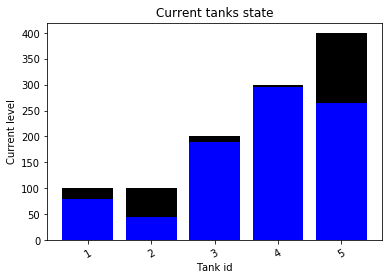

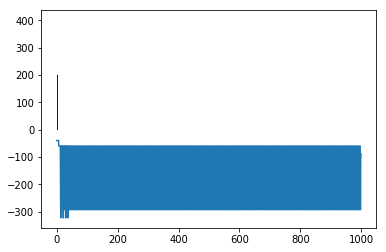

In [13]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
plt.show()

In [14]:
# Visualizing train simulation:
train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
HTML(train_anim.to_html5_video())

IndexError: list index out of range

In [ ]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))